In [2]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.examples.tutorials.mnist import input_data

# Import Fashion MNIST
fashion_mnist = input_data.read_data_sets('input/data', one_hot=True)


Extracting input/data/train-images-idx3-ubyte.gz
Extracting input/data/train-labels-idx1-ubyte.gz
Extracting input/data/t10k-images-idx3-ubyte.gz
Extracting input/data/t10k-labels-idx1-ubyte.gz


In [3]:
# Shapes of training set
print("Training set (images) shape: {shape}".format(shape=fashion_mnist.train.images.shape))
print("Training set (labels) shape: {shape}".format(shape=fashion_mnist.train.labels.shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=fashion_mnist.test.images.shape))
print("Test set (labels) shape: {shape}".format(shape=fashion_mnist.test.labels.shape))


Training set (images) shape: (55000, 784)
Training set (labels) shape: (55000, 10)
Test set (images) shape: (10000, 784)
Test set (labels) shape: (10000, 10)


In [4]:
# Create dictionary of target classes
label_dict = {
 0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'
}

In [5]:
# Sample 1

# Get 28x28 image
sample_1 = fashion_mnist.train.images[47].reshape(28,28)
# Get corresponding integer label from one-hot encoded data
sample_label_1 = np.where(fashion_mnist.train.labels[47] == 1)[0][0]
# Plot sample
print("y = {label_index} ({label})".format(label_index=sample_label_1, label=label_dict[sample_label_1]))
plt.imshow(sample_1, cmap='Greys')


y = 4 (Coat)


In [10]:
# Network parameters
n_hidden_1 = 128 # Units in first hidden layer
n_hidden_2 = 128 # Units in second hidden layer
n_input = 784 # Fashion MNIST data input (img shape: 28*28)
n_classes = 10 # Fashion MNIST total classes (0–9 digits)
n_samples = fashion_mnist.train.num_examples # Number of examples in training set 

In [12]:
# Create placeholders
def create_placeholders(n_x, n_y):
 '''
 Creates the placeholders for the tensorflow session.
 
 Arguments:
 n_x -- scalar, size of an image vector (28*28 = 784)
 n_y -- scalar, number of classes (10)
 
 Returns:
 X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
 Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
 '''
 
 X = tf.placeholder(tf.float32, [n_x, None], name="X")
 Y = tf.placeholder(tf.float32, [n_y, None], name="Y")
 
 return X, Y

In [13]:
def initialize_parameters():
    '''
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [n_hidden_1, n_input]
                        b1 : [n_hidden_1, 1]
                        W2 : [n_hidden_2, n_hidden_1]
                        b2 : [n_hidden_2, 1]
                        W3 : [n_classes, n_hidden_2]
                        b3 : [n_classes, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    '''
    
    # Set random seed for reproducibility
    tf.set_random_seed(42)
    
    # Initialize weights and biases for each layer
    # First hidden layer
    W1 = tf.get_variable("W1", [n_hidden_1, n_input], initializer=tf.contrib.layers.xavier_initializer(seed=42))
    b1 = tf.get_variable("b1", [n_hidden_1, 1], initializer=tf.zeros_initializer())
    
    # Second hidden layer
    W2 = tf.get_variable("W2", [n_hidden_2, n_hidden_1], initializer=tf.contrib.layers.xavier_initializer(seed=42))
    b2 = tf.get_variable("b2", [n_hidden_2, 1], initializer=tf.zeros_initializer())
    
    # Output layer
    W3 = tf.get_variable("W3", [n_classes, n_hidden_2], initializer=tf.contrib.layers.xavier_initializer(seed=42))
    b3 = tf.get_variable("b3", [n_classes, 1], initializer=tf.zeros_initializer())
    
    # Store initializations as a dictionary of parameters
    parameters = {
        "W1": W1,
        "b1": b1,
        "W2": W2,
        "b2": b2,
        "W3": W3,
        "b3": b3
    }
    
    return parameters

In [14]:
def forward_propagation(X, parameters):
    '''
    Implements the forward propagation for the model: 
    LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters
    Returns:
    Z3 -- the output of the last LINEAR unit
    '''
    
    # Retrieve parameters from dictionary
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    # Carry out forward propagation      
    Z1 = tf.add(tf.matmul(W1,X), b1)     
    A1 = tf.nn.relu(Z1)                  
    Z2 = tf.add(tf.matmul(W2,A1), b2)    
    A2 = tf.nn.relu(Z2)                  
    Z3 = tf.add(tf.matmul(W3,A2), b3)    
    
    return Z3


In [15]:
def compute_cost(Z3, Y):
    '''
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (10, number_of_examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    '''
    
    # Get logits (predictions) and labels
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    # Compute cost
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    
    return cost

In [16]:
def model(train, test, learning_rate=0.0001, num_epochs=16, minibatch_size=32, print_cost=True, graph_filename='costs'):
    '''
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    train -- training set
    test -- test set
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every epoch
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    '''
    
    # Ensure that model can be rerun without overwriting tf variables
    ops.reset_default_graph()
    # For reproducibility
    tf.set_random_seed(42)
    seed = 42
    # Get input and output shapes
    (n_x, m) = train.images.T.shape
    n_y = train.labels.T.shape[0]
    
    costs = []
    
    # Create placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)
    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation
    Z3 = forward_propagation(X, parameters)
    # Cost function
    cost = compute_cost(Z3, Y)
    # Backpropagation (using Adam optimizer)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    # Initialize variables
    init = tf.global_variables_initializer()
    
    # Start session to compute Tensorflow graph
    with tf.Session() as sess:
        
        # Run initialization
        sess.run(init)
        
        # Training loop
        for epoch in range(num_epochs):
            
            epoch_cost = 0.
            num_minibatches = int(m / minibatch_size)
            seed = seed + 1
            
            for i in range(num_minibatches):
                
                # Get next batch of training data and labels
                minibatch_X, minibatch_Y = train.next_batch(minibatch_size)
                
                # Execute optimizer and cost function
                _, minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X.T, Y: minibatch_Y.T})
                
                # Update epoch cost
                epoch_cost += minibatch_cost / num_minibatches
                
            # Print the cost every epoch
            if print_cost == True:
                print("Cost after epoch {epoch_num}: {cost}".format(epoch_num=epoch, cost=epoch_cost))
                costs.append(epoch_cost)
        
        # Plot costs
        plt.figure(figsize=(16,5))
        plt.plot(np.squeeze(costs), color='#2A688B')
        plt.xlim(0, num_epochs-1)
        plt.ylabel("cost")
        plt.xlabel("iterations")
        plt.title("learning rate = {rate}".format(rate=learning_rate))
        plt.savefig(graph_filename, dpi=300)
        plt.show()
        
        # Save parameters
        parameters = sess.run(parameters)
        print("Parameters have been trained!")
        
        # Calculate correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))
        
        # Calculate accuracy on test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        
        print ("Train Accuracy:", accuracy.eval({X: train.images.T, Y: train.labels.T}))
        print ("Test Accuracy:", accuracy.eval({X: test.images.T, Y: test.labels.T}))
        
        return parameters

Cost after epoch 0: 0.2999927553741801
Cost after epoch 1: 0.12915908915751811
Cost after epoch 2: 0.08698756537401281
Cost after epoch 3: 0.06420325544203065
Cost after epoch 4: 0.049128435151951005
Cost after epoch 5: 0.03882518518559964
Cost after epoch 6: 0.030755277924573086
Cost after epoch 7: 0.025397170408800785
Cost after epoch 8: 0.021990023950122874
Cost after epoch 9: 0.017867497533380374
Cost after epoch 10: 0.014625510046145554
Cost after epoch 11: 0.012923899412782944
Cost after epoch 12: 0.01317710575355734
Cost after epoch 13: 0.01052344271707233
Cost after epoch 14: 0.008381114002710506
Cost after epoch 15: 0.010764200634960225


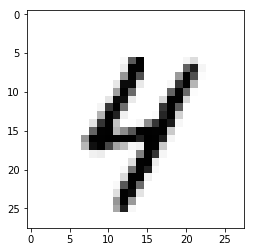

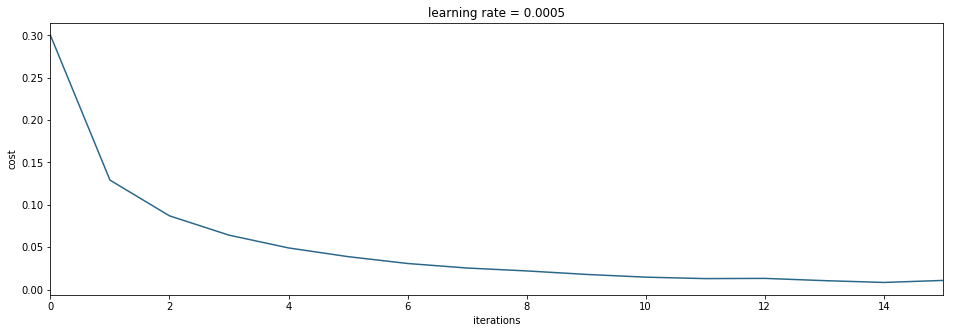

Parameters have been trained!
Train Accuracy: 0.996891
Test Accuracy: 0.9752


In [17]:
# Running our model
train = fashion_mnist.train
test = fashion_mnist.test

parameters = model(train, test, learning_rate=0.0005)
